In [1]:
import requests
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
from io import BytesIO
import math
import os
import json
import numpy as np

# --- ⚙️ 配置 ---
IMG_DIR = "./assets/city_networks_v7_1" # 新文件夹
DATA_DIR = "./data"
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)
JSON_NAME = "china_city_networks_v7_1.json"

# --- 🎨 你的定制调色板 (RGBA) ---
# 确保颜色正确
PALETTE = {
    'bg':    (255, 255, 255, 255), # 背景：纯白
    'road':  (0, 77, 127, 255),    # 道路：#004d7f (深蓝)
    'water': (160, 223, 247, 255), # 水体：#a0dff7 (浅蓝)
    'green': (212, 225, 164, 255), # 绿地：#D4E1A4 (浅绿)
    'rail':  (168, 49, 36, 255)    # 铁路：#a83124 (深红)
}

# 源地址
URL_VOYAGER = "https://a.basemaps.cartocdn.com/rastertiles/voyager_nolabels/{z}/{x}/{y}@2x.png"
URL_DARK = "https://a.basemaps.cartocdn.com/dark_nolabels/{z}/{x}/{y}@2x.png"
URL_ORM = "https://a.tiles.openrailwaymap.org/signals/{z}/{x}/{y}.png"

# 测试城市 (武汉长江是最好的试金石)
DATA_SOURCE = {
    "画家算法测试": [
        ("wuhan", "武汉", 30.5928, 114.3055, 12), 
        ("zhengzhou", "郑州", 34.7466, 113.6253, 12),
        ("hangzhou", "杭州", 30.2741, 120.1551, 12),
    ]
}

In [ ]:

# --- 工具函数 (保持不变) ---
def latlon_to_tile(lat, lon, zoom):
    n = 2.0 ** zoom
    xtile = int((lon + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.log(math.tan(math.radians(lat)) + (1 / math.cos(math.radians(lat)))) / math.pi) / 2.0 * n)
    return xtile, ytile

def download_image(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        if "openrailwaymap" in url: headers['Referer'] = 'https://www.openrailwaymap.org/'
        r = requests.get(url, headers=headers, timeout=10)
        if r.status_code == 200: return Image.open(BytesIO(r.content)).convert("RGBA")
    except: pass
    return None

# --- 🧪 核心：画家算法合成 ---
def composite_map_painter(img_voyager, img_dark, img_rail):
    width, height = img_voyager.size
    arr_v = np.array(img_voyager) # 全彩源
    arr_d = np.array(img_dark)    # 暗黑源

    # 🔥 第一步：创建画布，默认全涂成道路颜色 (深蓝)
    # 使用 uint8 类型以匹配图像数据
    final_arr = np.full((height, width, 4), PALETTE['road'], dtype=np.uint8)

    # 🔥 第二步：利用 Dark Map 挖出背景
    # 在Dark图中，亮度低的地方就是背景。我们把这些地方涂成白色。
    # 阈值 40：只要不是明显的灰/白线条，都算背景。
    brightness_d = np.mean(arr_d[:,:,:3], axis=2)
    mask_bg = (brightness_d < 40)
    final_arr[mask_bg] = PALETTE['bg']
    
    # (此时状态：白底 + 深蓝路网)

    # 🔥 第三步：利用 Voyager Map 覆盖绿地
    # 规则：绿色通道明显亮于红蓝通道
    mask_green = (arr_v[:,:,1] > arr_v[:,:,0] + 15) & (arr_v[:,:,1] > arr_v[:,:,2] + 15)
    final_arr[mask_green] = PALETTE['green']

    # 🔥 第四步：利用 Voyager Map 覆盖水体 (最高地理层级)
    # 规则：蓝色通道明显亮于红绿通道。阈值设高点(+30)确保只抓纯水。
    mask_water = (arr_v[:,:,2] > arr_v[:,:,0] + 30) & (arr_v[:,:,2] > arr_v[:,:,1] + 30)
    final_arr[mask_water] = PALETTE['water']

    # 转回 PIL 图片
    base_map = Image.fromarray(final_arr)

    # 🔥 第五步：叠加铁路 (顶层)
    if img_rail:
        # 尺寸对齐
        if img_rail.size != base_map.size:
            img_rail = img_rail.resize(base_map.size, Image.LANCZOS)
        # 腐蚀变细
        alpha = img_rail.getchannel('A')
        thinned_alpha = alpha.filter(ImageFilter.MinFilter(3))
        # 染色 (深红)
        rail_layer = Image.new("RGBA", base_map.size, PALETTE['rail'])
        rail_layer.putalpha(thinned_alpha)
        # 合成
        base_map = Image.alpha_composite(base_map, rail_layer)

    return base_map

def generate_perfect_map(cid, name, lat, lon, zoom):
    # 强制 Zoom 策略
    final_zoom = zoom
    range_offset = 1
    
    center_x, center_y = latlon_to_tile(lat, lon, final_zoom)
    TILE_SIZE = 512
    width = TILE_SIZE * (range_offset * 2 + 1)
    height = TILE_SIZE * (range_offset * 2 + 1)
    
    full_voyager = Image.new('RGBA', (width, height))
    full_dark = Image.new('RGBA', (width, height))
    full_rail = Image.new('RGBA', (width, height))
    
    print(f"🎨 [V7.1] 正在画家算法渲染: {name} (z{final_zoom})...", end="")
    
    for dx in range(-range_offset, range_offset + 1):
        for dy in range(-range_offset, range_offset + 1):
            xtile = center_x + dx
            ytile = center_y + dy
            px = (dx + range_offset) * TILE_SIZE
            py = (dy + range_offset) * TILE_SIZE
            
            # 下载三个源
            img_v = download_image(URL_VOYAGER.format(z=final_zoom, x=xtile, y=ytile))
            if img_v:
                if img_v.size != (TILE_SIZE, TILE_SIZE): img_v = img_v.resize((TILE_SIZE, TILE_SIZE), Image.LANCZOS)
                full_voyager.paste(img_v, (px, py))
            
            img_d = download_image(URL_DARK.format(z=final_zoom, x=xtile, y=ytile))
            if img_d:
                if img_d.size != (TILE_SIZE, TILE_SIZE): img_d = img_d.resize((TILE_SIZE, TILE_SIZE), Image.LANCZOS)
                full_dark.paste(img_d, (px, py))

            img_r = download_image(URL_ORM.format(z=final_zoom, x=xtile, y=ytile))
            if img_r:
                 # 铁路先攒着，最后拼
                 if img_r.size != (TILE_SIZE, TILE_SIZE): img_r = img_r.resize((TILE_SIZE, TILE_SIZE), Image.LANCZOS)
                 full_rail.paste(img_r, (px, py))

    # 执行新的合成算法
    final_image = composite_map_painter(full_voyager, full_dark, full_rail)
    
    # 缩放保存
    if final_image.width > 1600:
        final_image = final_image.resize((1536, 1536), Image.LANCZOS)
        
    save_path = f"{IMG_DIR}/{cid}.png"
    final_image.convert("RGB").save(save_path, quality=95)
    print(" ✅ 完成")
    return final_zoom


In [ ]:
zoom = 13

In [98]:
item = ("haikou", "海口", 19.99, 110.28, 12)
cid, name, lat, lon, initial_zoom = item
final_zoom = initial_zoom
range_offset=1
center_x, center_y = latlon_to_tile(lat, lon, final_zoom)
TILE_SIZE = 512
width = TILE_SIZE * (range_offset * 2 + 1)
height = TILE_SIZE * (range_offset * 2 + 1)

full_voyager = Image.new('RGBA', (width, height))
full_dark = Image.new('RGBA', (width, height))
full_rail = Image.new('RGBA', (width, height))

print(f"🎨 [V7.1] 正在画家算法渲染: {name} (z{final_zoom})...", end="")


for dx in range(-range_offset, range_offset + 1):
    for dy in range(-range_offset, range_offset + 1):
        xtile = center_x + dx
        ytile = center_y + dy
        px = (dx + range_offset) * TILE_SIZE
        py = (dy + range_offset) * TILE_SIZE
        
        # 下载三个源
        img_v = download_image(URL_VOYAGER.format(z=final_zoom, x=xtile, y=ytile))
        if img_v:
            if img_v.size != (TILE_SIZE, TILE_SIZE): img_v = img_v.resize((TILE_SIZE, TILE_SIZE), Image.LANCZOS)
            full_voyager.paste(img_v, (px, py))
        
        img_d = download_image(URL_DARK.format(z=final_zoom, x=xtile, y=ytile))
        if img_d:
            if img_d.size != (TILE_SIZE, TILE_SIZE): img_d = img_d.resize((TILE_SIZE, TILE_SIZE), Image.LANCZOS)
            full_dark.paste(img_d, (px, py))

        img_r = download_image(URL_ORM.format(z=final_zoom, x=xtile, y=ytile))
        if img_r:
                # 铁路先攒着，最后拼
                if img_r.size != (TILE_SIZE, TILE_SIZE): img_r = img_r.resize((TILE_SIZE, TILE_SIZE), Image.LANCZOS)
                full_rail.paste(img_r, (px, py))

        




🎨 [V7.1] 正在画家算法渲染: 海口 (z12)...

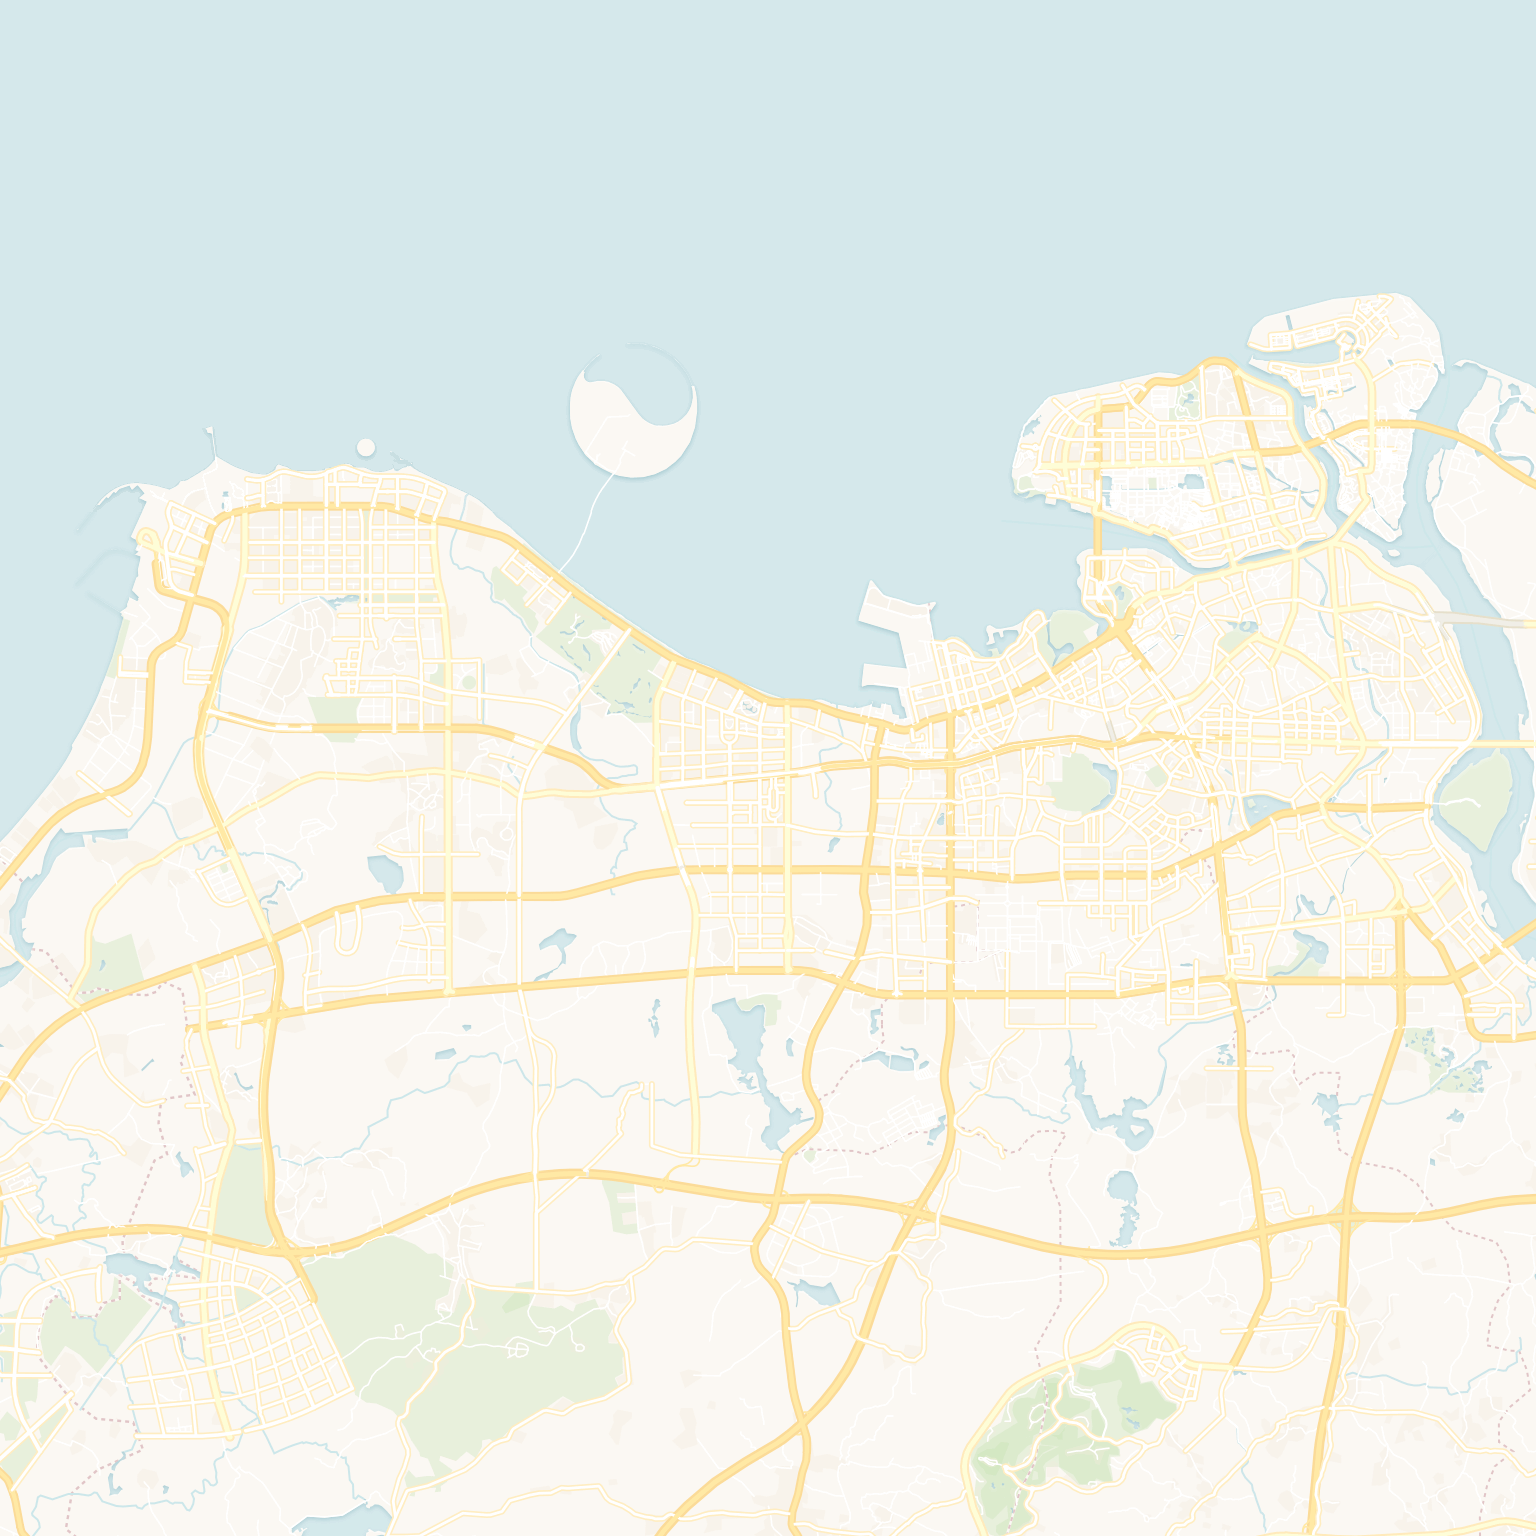

In [99]:
full_voyager

In [96]:
plt.imshow(arr_v[:,:,0]<arr_v[:,:,1])
plt.colorbar()

In [56]:
# plt.hist(arr_v[:,:,0].reshape(-1))
# plt.hist(arr_v[:,:,1].reshape(-1))
plt.hist(arr_v[:,:,2].reshape(-1))


(array([  35698.,   58124.,    9186.,  121842.,   63808.,   63496.,
         220944.,  178684., 1305577.,  301937.]),
 array([152. , 162.3, 172.6, 182.9, 193.2, 203.5, 213.8, 224.1, 234.4,
        244.7, 255. ]),
 <BarContainer object of 10 artists>)

In [97]:
enhancer = ImageEnhance.Contrast(full_dark)
enhanced_full_dark = enhancer.enhance(10)

width, height = full_dark.size
arr_v = np.array(full_voyager) # 全彩源
arr_d = np.array(full_dark)    # 暗黑源

# 🔥 第一步：创建画布，默认全涂成道路颜色 (深蓝)
# 使用 uint8 类型以匹配图像数据
final_arr = np.full((height, width, 4), PALETTE['road'], dtype=np.uint8)

# 🔥 第二步：利用 Dark Map 挖出背景
# 在Dark图中，亮度低的地方就是背景。我们把这些地方涂成白色。
# 阈值 40：只要不是明显的灰/白线条，都算背景。
array_img_d = np.array(enhanced_full_dark)
brightness_d = np.mean(array_img_d[:,:,:3], axis=2)
mask_bg = (brightness_d < 80)
arr_v = np.array(full_voyager)
final_arr[mask_bg] = PALETTE['bg']
mask_green = (arr_v[:,:,1] > 200)&(arr_v[:,:,1] < 245) &(arr_v[:,:,0] < 235)&(arr_v[:,:,0] > 170) & (arr_v[:,:,2] < 240)& (arr_v[:,:,2] > 150)&(arr_v[:,:,0]<arr_v[:,:,1])
final_arr[mask_green] = PALETTE['green']


mask_water = (arr_v[:,:,0] > 190)&(arr_v[:,:,0]<220) & (arr_v[:,:,1] > 210) & (arr_v[:,:,1] < 240)&(arr_v[:,:,2] > 220)&(arr_v[:,:,2]<250)
final_arr[mask_water] = PALETTE['water']

# 转回 PIL 图片
base_map = Image.fromarray(final_arr)
base_map
# light-blue: rgba(196, 221, 224, 1)
# beige: rgba(232, 240, 220, 1)

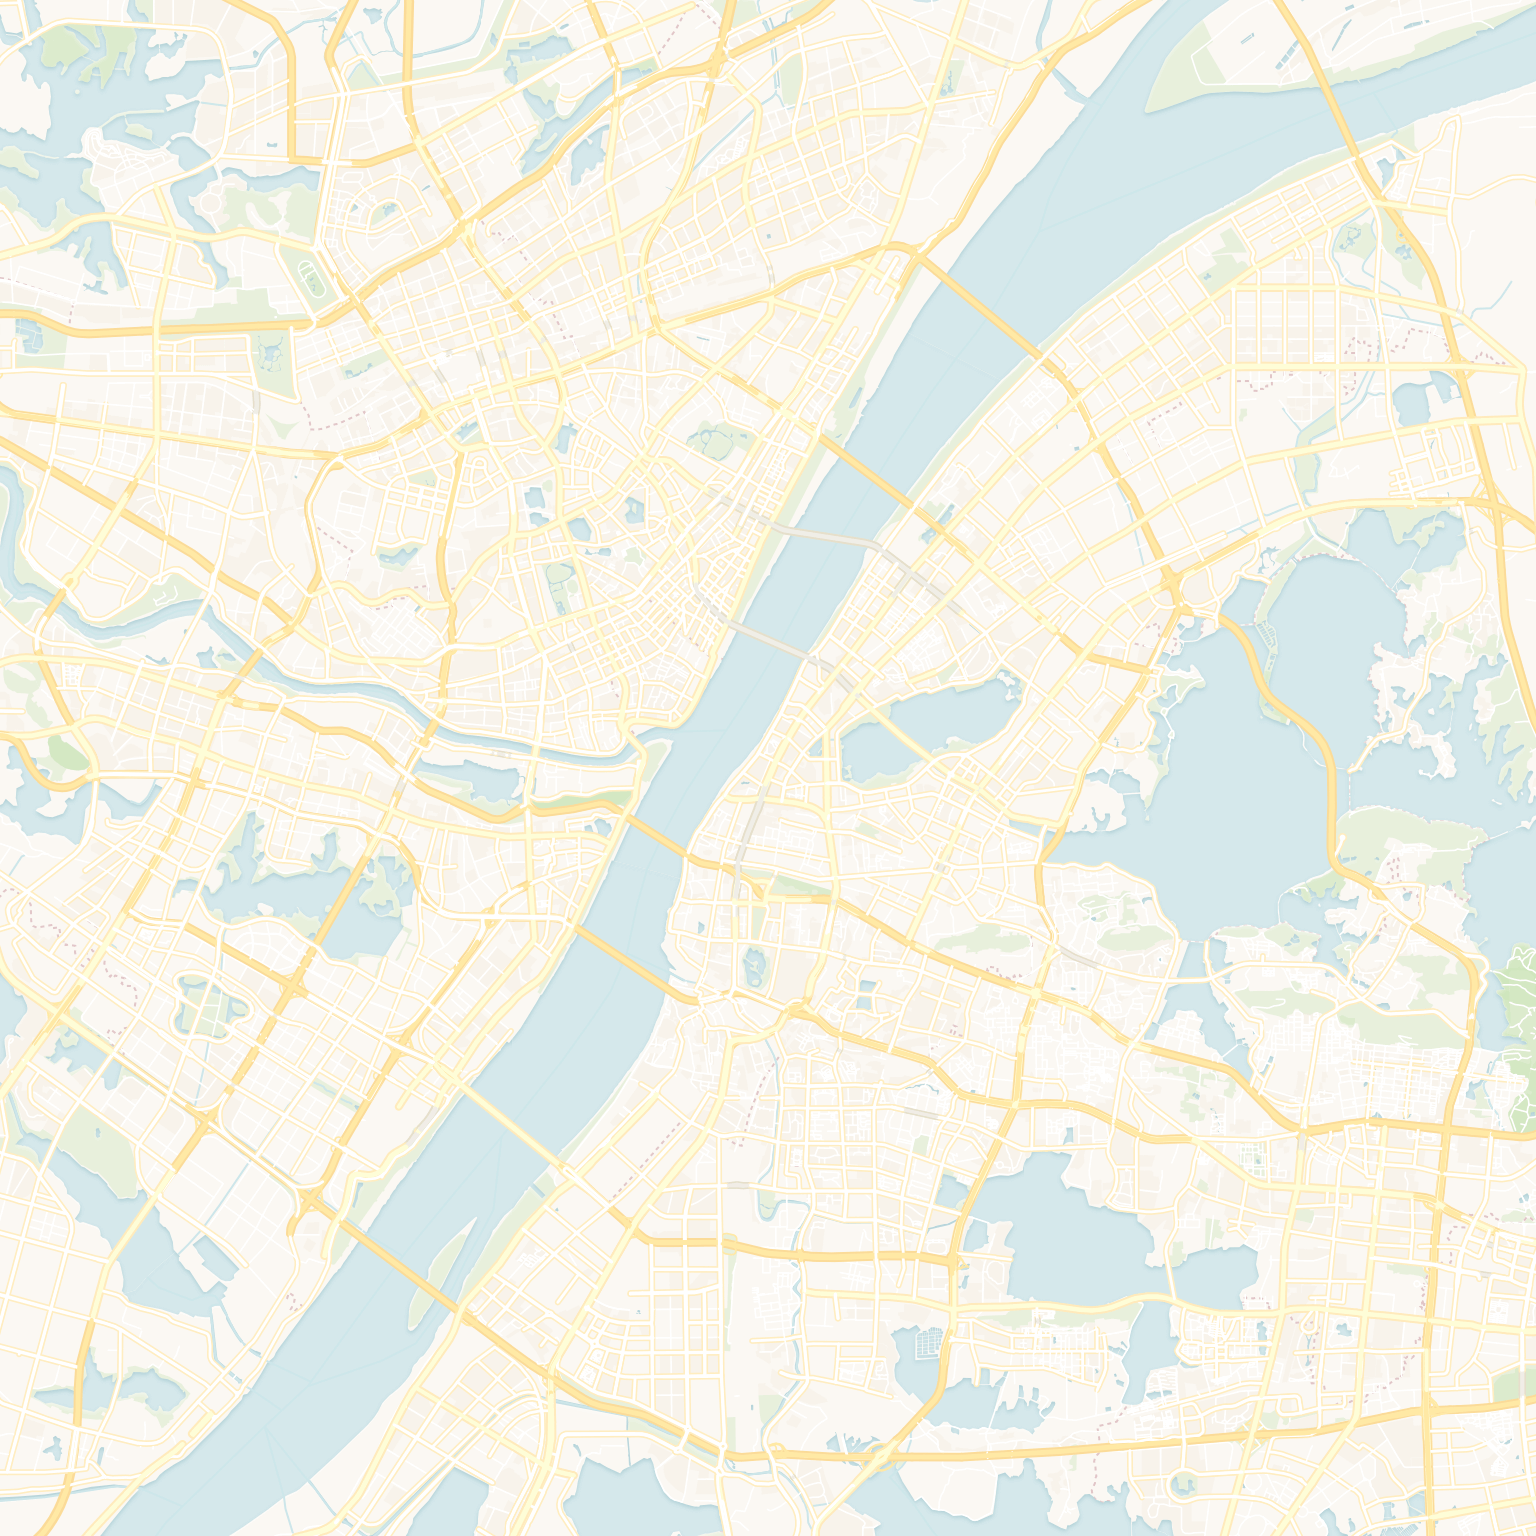

In [ ]:
for dx in range(-range_offset, range_offset + 1):
    for dy in range(-range_offset, range_offset + 1):
        xtile = center_x + dx
        ytile = center_y + dy
        px = (dx + range_offset) * TILE_SIZE
        py = (dy + range_offset) * TILE_SIZE
        
        # 下载三个源
        img_v = download_image(URL_VOYAGER.format(z=final_zoom, x=xtile, y=ytile))
        if img_v:
            if img_v.size != (TILE_SIZE, TILE_SIZE): img_v = img_v.resize((TILE_SIZE, TILE_SIZE), Image.LANCZOS)
            full_voyager.paste(img_v, (px, py))
        
        img_d = download_image(URL_DARK.format(z=final_zoom, x=xtile, y=ytile))
        if img_d:
            if img_d.size != (TILE_SIZE, TILE_SIZE): img_d = img_d.resize((TILE_SIZE, TILE_SIZE), Image.LANCZOS)
            full_dark.paste(img_d, (px, py))

        img_r = download_image(URL_ORM.format(z=final_zoom, x=xtile, y=ytile))
        if img_r:
                # 铁路先攒着，最后拼
                if img_r.size != (TILE_SIZE, TILE_SIZE): img_r = img_r.resize((TILE_SIZE, TILE_SIZE), Image.LANCZOS)
                full_rail.paste(img_r, (px, py))


In [ ]:
enhancer = ImageEnhance.Contrast(img_d)
enhanced = enhancer.enhance(10)
